In [1]:
import csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tensorflow.keras.utils import (
    Sequence,
)  # needed if more than one feature is fed into model

2023-12-14 16:43:20.013428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Define two different ways of preprocessing the data


def pre_process_Zscore(prices):
    # Split data into training and test set
    training_data = prices[: int(0.8 * len(prices))]
    test_data = prices[int(0.8 * len(prices)) :]

    # apply Z-score scaling to normalize the data:
    # Compute the mean and standard deviation
    mean_training = np.mean(training_data)
    std_dev_training = np.std(training_data)

    mean_test = np.mean(test_data)
    std_dev_test = np.std(test_data)

    # Apply Z-score scaling (standardization)
    training_data_scaled = (training_data - mean_training) / std_dev_training
    test_data_scaled = (test_data - mean_test) / std_dev_test

    return training_data_scaled, test_data_scaled, mean_test, std_dev_test


def pre_process_maxmin(prices):
    # Split data into training and test set
    training_data = prices[: int(0.8 * len(prices))]
    test_data = prices[int(0.8 * len(prices)) :]

    # compute max-min normalization
    training_data_scaled = (training_data - training_data.min()) / (
        training_data.max() - training_data.min()
    )
    test_data_scaled = (test_data - test_data.min()) / (
        test_data.max() - test_data.min()
    )

    return training_data_scaled, test_data_scaled, training_data, test_data

In [3]:
class StockSequence(Sequence):
    def __init__(self, prices, volumes, ETF_prices, batch_size, sequence_length):
        self.prices = prices
        self.volumes = volumes
        self.ETF_prices = ETF_prices
        self.batch_size = batch_size
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.prices) - self.sequence_length

    def __getitem__(self, index):
        start_index = index
        end_index = index + self.sequence_length
        price_sequence = self.prices[start_index:end_index]
        volume_sequence = self.volumes[start_index:end_index]
        ETF_price_sequence = self.ETF_prices[start_index:end_index]

        # Return the sequences as inputs and targets
        inputs = np.column_stack((price_sequence, volume_sequence, ETF_price_sequence))
        price_targets = self.prices[end_index]

        return inputs, price_targets
    

In [4]:
# Download using yfinance
nasdaq_100 = yf.download(tickers="qqq", period="max", interval="1d")
google = yf.download(tickers="GOOGL", period="max", interval="1d")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# preprocess data for stock and index:
# get closing data:
google_close = google["Close"]
google_vols = google["Volume"][google_close.index[0] :]
# read closing dates only from starting date of Google onwards
nasdaq_100_close = nasdaq_100["Close"][google_close.index[0] :]


google_close_training_scaled, google_close_test_scaled, goole_close_training, google_close_test = pre_process_maxmin(google_close)
google_vols_training_scaled, google_vols_test_scaled, goole_vols_training, google_vols_test = pre_process_maxmin(google_vols)
nasdaq_100_training_scaled, nasdaq_100_test_scaled, nasdaq_100_training, nasdaq_100_test = pre_process_maxmin(nasdaq_100_close)



In [6]:
# Sequence generation
sequence_length = 10  # Length of input sequences
batch_size = 32

# Generate input sequences
training_data = StockSequence(
    google_close_training_scaled.values, google_vols_training_scaled.values, nasdaq_100_training_scaled.values, batch_size, sequence_length
)
nbr_features = training_data[0][0].shape[1]
print("number of features detcted: " , nbr_features)

number of features detcted:  3


In [7]:
# Define the model architecture
model = Sequential()

# for sequential model:
nbr_features = 1
input_data = np.array([training_data[i][0][:,0] for i in range (len(training_data))])#pure price input data
#model.add(Dense(64, activation='relu',input_shape=(sequence_length,)))


# for LSTM:
nbr_features = 3
input_data = np.array([training_data[i][0] for i in range (len(training_data))])#input data with 3 features
model.add(LSTM(64, activation="relu", input_shape=(sequence_length,nbr_features), return_sequences=False))#
#model.add(LSTM(64, activation="relu"))

model.add(Dense(32, activation="relu"))
#model.add(Dense(32, activation="relu"))
#model.add(Dense(32, activation="relu"))
model.add(Dense(1))  # Output layer with 1 neuron for regression

# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam")

# Train the model
target_data = np.array([training_data[i][1] for i in range (len(training_data))])


model.fit(input_data, target_data, epochs=10, batch_size=32)

Epoch 1/10
122/122 [==============================] - 2s 3ms/step - loss: 0.0087
Epoch 2/10
122/122 [==============================] - 0s 3ms/step - loss: 2.4996e-04
Epoch 3/10
122/122 [==============================] - 1s 4ms/step - loss: 1.1248e-04
Epoch 4/10
122/122 [==============================] - 0s 3ms/step - loss: 1.0465e-04
Epoch 5/10
122/122 [==============================] - 0s 3ms/step - loss: 1.0672e-04
Epoch 6/10
122/122 [==============================] - 0s 3ms/step - loss: 1.1053e-04
Epoch 7/10
122/122 [==============================] - 0s 3ms/step - loss: 9.6089e-05
Epoch 8/10
122/122 [==============================] - 0s 3ms/step - loss: 9.1952e-05
Epoch 9/10
122/122 [==============================] - 0s 3ms/step - loss: 1.0051e-04
Epoch 10/10
122/122 [==============================] - 0s 3ms/step - loss: 9.3935e-05


31/31 [==============================] - 0s 1ms/step
(963,)
Mean squared error:  12.771894168643254
Mean absolute error:  2.6594650292322273


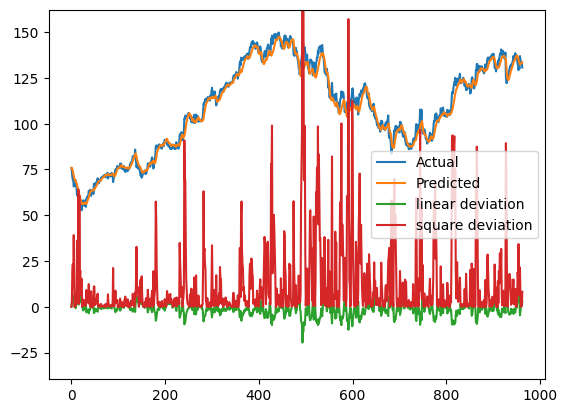

In [8]:
# Perform predictions
# Generate input sequences
test_data = StockSequence(
    google_close_test_scaled.values, google_vols_test_scaled.values, nasdaq_100_test_scaled.values, batch_size, sequence_length
)


#test_data_pure_price = np.array([test_data[i][0][:,0] for i in range (len(test_data))])
#predictions = model.predict(test_data_pure_price)

test_data_with_features = np.array([test_data[i][0] for i in range (len(test_data))])
predictions = model.predict(test_data_with_features)


#convert to non-rescaled values:
predictions *= (google_close_test.max() - google_close_test.min()) 
predictions += google_close_test.min()

target_sequences_test = google_close_test[sequence_length:].values

assert len(target_sequences_test) == len(
    predictions
), "Predictions and actual data have different length" 
# Evaluate the performance
# Calculate the mean squared error (MSE)
predictions = predictions.ravel()
target_sequences_test = target_sequences_test.ravel()
mse = np.mean((target_sequences_test - predictions) ** 2)

# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(target_sequences_test - predictions))
print(target_sequences_test.shape)
# Visualize the results
fig, (ax1) = plt.subplots(1)
ax1.plot(target_sequences_test[:], label="Actual")
ax1.plot(predictions[:], label="Predicted")
ax1.plot((((predictions-target_sequences_test))), label="linear deviation")
ax1.plot(((predictions-target_sequences_test)**2), label="square deviation")
ax1.legend()

ax1.set_ylim(top = 1.1* np.max(predictions))
print("Mean squared error: ", mse)
print("Mean absolute error: ", mae)
# ax2.plot(mse, label='Mean Squared Error')
# ax2.legend()

plt.show()